In [23]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# The age-metallicity structure of the Milky Way disk

This IPython notebook runs through all the necessary steps to reproduce the results found in the Mackereth et al. (2017). In order for the following code to work, the user must have pre-calculated the required isochrone grid (using make_isochrone_grids.py), the effective selection function for the mono-age, mono-[Fe/H] populations used for the paper (using calc_effsel_monoage.py) and then downloaded the relevant age and distance tables for the APOGEE-DR12 data (see readme), and placed these in the 'catalogues' directory.

The first section goes through the plots used in the Data section of the paper. Section 2 contains cells which perform the density fits, and the surface-mass density calculation (calling the isochrone grids). The fits and the mass calculations can take a fair amount of time, and require multiprocessing. Section 3 guides the user through the creation of the plots in sections 4 and 5 of the paper (including the plots in the Appendix), which form the bulk of the science results.

## Section 1 - General Plots

In [38]:
try:
    reload(densprofiles)
    reload(define_rgbsample)
    reload(fitDens)
    reload(fitDens.densprofiles)
    reload(compareDataModel)
    reload(mockDensData)
except NameError:
    import densprofiles
    import define_rgbsample
    import fitDens
    import compareDataModel
    import mockDensData
%pylab inline
import numpy
from matplotlib.pyplot import *
import matplotlib.gridspec as gridspec
import os, os.path
import pickle
import copy
from galpy.util import bovy_plot, bovy_coords
import corner
import mwdust
import fitsio
from scipy.interpolate import interp1d
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

params = {'axes.labelsize': 14, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'text.usetex': True, 'lines.linewidth' : 1, 'axes.titlesize' : 14, 'font.family' : 'serif'}
plt.rcParams.update(params)


columnwidth = 240./72.27
textwidth = 504.0/72.27

selectFile= '../savs/selfunc-nospdata.sav'
if os.path.exists(selectFile):
    with open(selectFile,'rb') as savefile:
        apo= pickle.load(savefile)
with open('../essf/maps/essf_rgb_green15_modelmh_feh-0.0_age1.0.sav','rb') as savefile:
    locations= pickle.load(savefile)
    effsel= pickle.load(savefile)
    distmods= pickle.load(savefile)
with open('../essf/maps/essf_rgb_marshall06_modelmh_feh-0.0_age1.0.sav','rb') as savefile:
    mlocations= pickle.load(savefile)
    meffsel= pickle.load(savefile)
    mdistmods= pickle.load(savefile)
# Fill in regions not covered by Marshall map
meffsel[meffsel < -0.5]= effsel[meffsel < -0.5]

# Get (lcen,bcen) for each location
lcen= numpy.zeros(len(locations))
bcen= numpy.zeros(len(locations))
hmax= numpy.zeros(len(locations))
for ii,loc in enumerate(locations):
    if loc in apo.list_fields():
        tlcen, tbcen= apo.glonGlat(loc)
        lcen[ii]= tlcen
        bcen[ii]= tbcen
        hmax[ii]= apo.Hmax(loc,cohort='long')
        if numpy.isnan(hmax[ii]):
            hmax[ii]= apo.Hmax(loc,cohort='medium')
            if numpy.isnan(hmax[ii]):
                hmax[ii]= apo.Hmax(loc,cohort='short')
    if loc not in apo.list_fields():
        lcen[ii] = numpy.nan
        bcen[ii] = numpy.nan
        hmax[ii]= numpy.nan

# Get the locations of various subsamples
highbIndx= numpy.fabs(bcen) > 10.
outDiskIndx= (lcen > 150.)*(lcen < 250.)*(True-highbIndx)
betwDiskIndx= (lcen <= 150.)*(lcen >= 70.)*(True-highbIndx)
inDiskIndx= (lcen < 70.)*(lcen >= 25.)*(True-highbIndx)
bulgeIndx= ((lcen < 25.)+(lcen > 335.))*(True-highbIndx)
brightIndx= (hmax <= 12.21)
mediumIndx= (hmax > 12.21)*(hmax <= 12.81)
faintIndx= (hmax > 12.81)


ldata= None
data_highbIndx= None
data_outDiskIndx= None
data_betwDiskIndx= None
data_inDiskIndx= None
data_bulgeIndx= None
data_brightIndx= None
data_mediumIndx= None
data_faintIndx= None
def load_data(subsample='lowlow', add_ages=False, agebin=[0.,1.], fehbin=[0.,0.2], afebin=None, agetype='Martig', corrections=False):
    global ldata
    global data_highbIndx
    global data_outDiskIndx
    global data_betwDiskIndx
    global data_inDiskIndx    
    global data_bulgeIndx    
    global data_brightIndx
    global data_mediumIndx
    global data_faintIndx
    if subsample.lower() == 'all':
        ldata= define_rgbsample.get_rgbsample(agetype=agetype)
    elif subsample.lower() == 'alllowalpha':
        ldata= define_rgbsample.get_rgbsample()
        ldata= ldata[ldata[define_rgbsample._AFETAG] < 0.1]
    elif subsample.lower() == 'lowlow':
        ldata= define_rgbsample.get_lowlowsample()
    elif subsample.lower() == 'highfeh':
        ldata= define_rgbsample.get_highfehsample()
    elif subsample.lower() == 'highalpha':
        ldata= define_rgbsample.get_highalphasample()
    elif subsample.lower() == 'solar':
        ldata= define_rgbsample.get_solarsample()
    elif subsample.lower() == 'fehage':
        ldata= define_rgbsample.get_fehage(agebin=agebin, fehbin=fehbin, afebin=afebin, agetype=agetype, apply_corrections=corrections)
    # Get the indices of the various subsamples defined above
    data_highbIndx= numpy.zeros(len(ldata),dtype='bool')
    for ii in range(len(ldata)):
        if ldata[ii]['LOCATION_ID'] in numpy.array(locations)[highbIndx]: data_highbIndx[ii]= True
    data_outDiskIndx= numpy.zeros(len(ldata),dtype='bool')
    for ii in range(len(ldata)):
        if ldata[ii]['LOCATION_ID'] in numpy.array(locations)[outDiskIndx]: data_outDiskIndx[ii]= True
    data_betwDiskIndx= numpy.zeros(len(ldata),dtype='bool')
    for ii in range(len(ldata)):
        if ldata[ii]['LOCATION_ID'] in numpy.array(locations)[betwDiskIndx]: data_betwDiskIndx[ii]= True
    data_inDiskIndx= numpy.zeros(len(ldata),dtype='bool')
    for ii in range(len(ldata)):
        if ldata[ii]['LOCATION_ID'] in numpy.array(locations)[inDiskIndx]: data_inDiskIndx[ii]= True
    data_bulgeIndx= numpy.zeros(len(ldata),dtype='bool')
    for ii in range(len(ldata)):
        if ldata[ii]['LOCATION_ID'] in numpy.array(locations)[bulgeIndx]: data_bulgeIndx[ii]= True
    data_brightIndx= numpy.zeros(len(ldata),dtype='bool')
    for ii in range(len(ldata)):
        if ldata[ii]['LOCATION_ID'] in numpy.array(locations)[brightIndx]: data_brightIndx[ii]= True
    data_mediumIndx= numpy.zeros(len(ldata),dtype='bool')
    for ii in range(len(ldata)):
        if ldata[ii]['LOCATION_ID'] in numpy.array(locations)[mediumIndx]: data_mediumIndx[ii]= True
    data_faintIndx= numpy.zeros(len(ldata),dtype='bool')
    for ii in range(len(ldata)):
        if ldata[ii]['LOCATION_ID'] in numpy.array(locations)[faintIndx]: data_faintIndx[ii]= True


Populating the interactive namespace from numpy and matplotlib
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:72: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:73: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:74: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:75: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.



`%matplotlib` prevents importing * from pylab and numpy


In [10]:
load_data(subsample='fehage', fehbin=[-0.6,0.2], agebin=[0.,13.], agetype='Martig', corrections=True)
def alphaedge(fehs):
    edge = np.zeros(len(fehs))
    edge[fehs < 0] = (0.12/-0.6)*fehs[fehs < 0]+0.03
    edge[fehs >= 0] = 0.03
    return edge


### Figure 1 - the $\mathrm{[\alpha/Fe]}$-$\mathrm{[Fe/H]}$ distribution

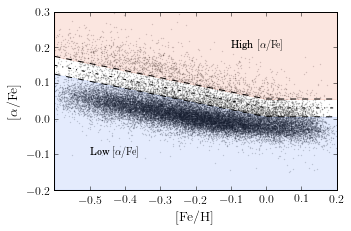

In [13]:

low = ldata['AVG_ALPHAFE'] <= alphaedge(ldata['FE_H']-0.025)
high = ldata['AVG_ALPHAFE'] > alphaedge(ldata['FE_H']+0.025)

fig = plt.figure()
fehs = np.linspace(-0.6, 0.2, 100)
plt.scatter(ldata['FE_H'], ldata['AVG_ALPHAFE'], s=2, alpha=0.2, edgecolor=None, color='black', lw=0.)
plt.plot(fehs, alphaedge(fehs)+0.025, color='black', linestyle='dashed')
plt.plot(fehs, alphaedge(fehs)-0.025, color='black', linestyle='dashed')
plt.plot(fehs, alphaedge(fehs), color='black', linestyle='dashdot')

plt.fill_between(fehs, alphaedge(fehs)+0.025, 0.3*np.ones(100), color=plt.cm.coolwarm(0.8), alpha=0.2)
plt.fill_between(fehs, -0.2*np.ones(100), alphaedge(fehs)-0.025, color=plt.cm.coolwarm(0.2), alpha=0.2)
plt.text(-0.1,0.2, r'High $\mathrm{[\alpha/Fe]}$')
plt.text(-0.5,-0.1, r'Low $\mathrm{[\alpha/Fe]}$')
plt.xlim(-0.6,0.2)
plt.ylim(-0.2,0.3)
plt.ylabel(r'$\mathrm{[\alpha/Fe]}$')
plt.xlabel(r'$\mathrm{[Fe/H]}$')
fig.set_size_inches(1.5*columnwidth, columnwidth)
fig.tight_layout()

### Figure 2 - the spatial distribution 

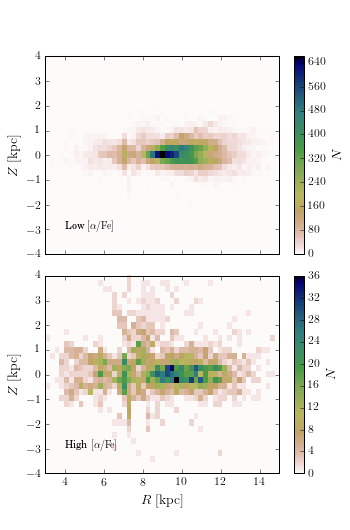

In [12]:
xbins = np.linspace(3.,15.,50)
ybins = np.linspace(-6.,6.,50)
fig, ax = plt.subplots(2,1, sharex=True, sharey=True)
s1 = ax[0].hist2d(ldata['MH50_GALR'][low], ldata['MH50_GALZ'][low], bins=[xbins,ybins], cmap=plt.cm.gist_earth_r)
s2 = ax[1].hist2d(ldata['MH50_GALR'][high], ldata['MH50_GALZ'][high], bins=[xbins,ybins], cmap=plt.cm.gist_earth_r)
ax[0].set_xlim(3.,15.)
ax[0].set_ylim(-4.,4.)
ax[0].set_ylabel(r'$Z\ \mathrm{[kpc]}$')
ax[1].set_ylabel(r'$Z\ \mathrm{[kpc]}$')
ax[1].set_xlabel(r'$R\ \mathrm{[kpc]}$')
#ax[0].set_xlabel(r'$R\ \mathrm{[Kpc]}$')
ax[0].text(4,-3, r'Low $\mathrm{[\alpha/Fe]}$')
ax[1].text(4,-3, r'High $\mathrm{[\alpha/Fe]}$')

plt.colorbar(s1[3], ax=ax[0], label=r'$N$')
plt.colorbar(s2[3], ax=ax[1], label=r'$N$')


fig.set_size_inches(1.5*columnwidth, 2*columnwidth)
fig.tight_layout()

### Figure 3 - Red-Clump distance comparison

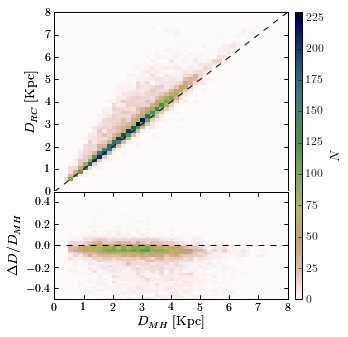

In [16]:
import define_rcsample
from astropy.table import Table, join
import mpl_toolkits.axisartist as AA 

dat = define_rcsample.get_rcsample()
ldat = define_rgbsample.get_rgbsample(add_ages=True)
rctab = Table(data=dat)
fulltab = Table(data=ldat)
tab = join(rctab,fulltab, keys='APOGEE_ID', uniq_col_name='{col_name}{table_name}', table_names=['RCLUMP',''])
distcomp = tab.as_array()


fig = plt.figure()
x = np.linspace(0.,8.,50)
y = np.linspace(0.,8.,50)

glatmask = (np.fabs(distcomp['GLAT']) > 6.)&(distcomp['FE_H'] >= -0.6)&(distcomp['FE_H'] <0.2)&(distcomp['Age'] < 13.)

ax1 = AA.Axes(fig,[0.2,0.45,0.65,0.5])
fig.add_axes(ax1)
s = ax1.hist2d(10**((distcomp['HAYDEN_DISTMOD_50']+5.)/5.)/1e3, 10**((distcomp['RC_DM_H']+5.)/5.)/1e3, bins=[x,y], cmap=plt.cm.gist_earth_r)

ax1.plot(x,y, color='Black', linestyle='dashed')
#
ax1.set_ylabel(r'$D_{RC}\ \mathrm{[Kpc]}$')
ax1.set_xticks([])

#ax1.set_ylim(-0.5,1.3)
ax2 = AA.Axes(fig,[0.2,0.15,0.65,0.3])
fig.add_axes(ax2)
x = 10**((distcomp['HAYDEN_DISTMOD_50']+5.)/5.)/1e3
y = 10**((distcomp['RC_DM_H']+5.)/5.)/1e3
delta = x-y
xbins = np.linspace(0.,8.,50)
ybins = np.linspace(-0.6,0.6,50)
ax2.hist2d(y,delta/x, bins=[xbins,ybins], cmap=plt.cm.gist_earth_r, vmin=0.,vmax=225.)
ax2.axhline(0, color='Black', linestyle='dashed')
ax2.set_ylabel(r'$\Delta D / D_{MH}$')
ax2.set_xlabel(r'$D_{MH}\ \mathrm{[Kpc]}$')
ax1.legend(loc=4)
ax2.set_ylim(-0.5,0.5)
ax2.set_yticks([-0.4,-0.2,0.,0.2,0.4])
#ax1.set_yticks([-0.4,0.,0.4,0.8,1.2])
fig.set_size_inches(1.5*columnwidth,1.5*columnwidth)
cax = fig.add_axes([0.87,0.15,0.02,0.8])
plt.colorbar(s[3], cax=cax, label=r'$N$')

### Figure 4 - Age correction fit 

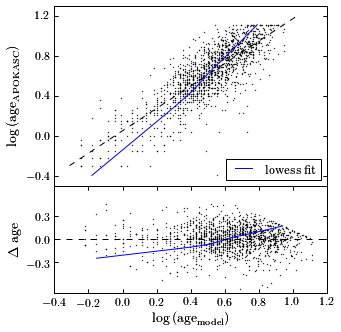

In [21]:
table = np.genfromtxt('../catalogues/martig2016_table1.txt', dtype=None, names=True, skip_header=2)
fig = plt.figure()
ax1 = AA.Axes(fig,[0.2,0.45,0.76,0.5])
fig.add_axes(ax1)
ax1.scatter(np.log10(table['Age_out']),np.log10(table['Age_in']), s=2, alpha=0.8, lw=0., color='Black')
xs = np.linspace(-0.3,1.2,100)
xsinterpolate = interp1d(xs,xs)
ax1.plot(xs,xs, color='Black', linestyle='dashed')
fit = lowess(np.log10(table['Age_out']),np.log10(table['Age_in']))#, delta=0.01, frac=0.5 )
ax1.plot(fit[:,1], fit[:,0], label='lowess fit')
#
ax1.set_ylabel(r'$\mathrm{\log{(age_{APOKASC})}}$')
ax1.set_xticks([])
fig.set_size_inches(columnwidth,columnwidth)
ax1.set_ylim(-0.5,1.3)
ax2 = AA.Axes(fig,[0.2,0.15,0.76,0.3])
fig.add_axes(ax2)
ax2.plot(fit[:,1], fit[:,0]-xsinterpolate(fit[:,1]))
ax2.scatter(np.log10(table['Age_out']),((np.log10(table['Age_in'])-np.log10(table['Age_out']))), s=2, alpha=0.8, lw=0., color='Black')
ax2.axhline(0, color='Black', linestyle='dashed')
ax2.set_ylabel(r'$\mathrm{\Delta\ age}$')
ax2.set_xlabel(r'$\mathrm{\log{(age_{model})}}$')
ax1.legend(loc=4)
ax2.set_ylim(-0.7,0.7)
ax2.set_yticks([-0.3,0.,0.3])
ax1.set_yticks([-0.4,0.,0.4,0.8,1.2])
fig.set_size_inches(1.5*columnwidth,1.5*columnwidth)


### Figure 5 - Raw star counts

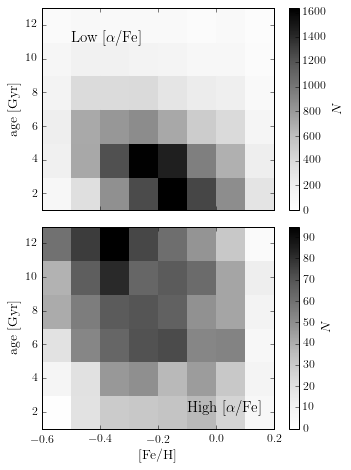

In [22]:
agebins = np.arange(1.,14.,2.)
fehbins = np.arange(-0.6,0.3,0.1)

hc_numbins = []
load_data(subsample='fehage', add_ages=True, agebin=[0., 13.], fehbin=[-0.6,0.2], afebin='highclean', agetype='Martig', corrections=True)
dat = ldata#[data_medbIndx]
for j in range(0,len(fehbins)-1):
    numbinfeh = []
    for i in range(0,len(agebins)-1):
        mask = (dat['Age'] >= agebins[i])&(dat['Age'] < agebins[i+1])&(dat['FE_H'] >= fehbins[j])&(dat['FE_H'] < fehbins[j+1])
        ldata = dat[mask]
        num_bin = len(ldata)
        numbinfeh.append(num_bin)
    hc_numbins.append(numbinfeh)
hc_numbins = np.array(hc_numbins)

lc_numbins = []
load_data(subsample='fehage', add_ages=True, agebin=[0., 13.], fehbin=[-0.6,0.2], afebin='lowclean', agetype='Martig', corrections=True)
dat = ldata#[data_medbIndx]
for j in range(0,len(fehbins)-1):
    numbinfeh = []
    for i in range(0,len(agebins)-1):
        mask = (dat['Age'] >= agebins[i])&(dat['Age'] < agebins[i+1])&(dat['FE_H'] >= fehbins[j])&(dat['FE_H'] < fehbins[j+1])
        ldata = dat[mask]
        num_bin = len(ldata)
        numbinfeh.append(num_bin)
    lc_numbins.append(numbinfeh)
lc_numbins = np.array(lc_numbins)

hc_nums = hc_numbins.ravel()
lc_nums = lc_numbins.ravel()
norm = mpl.colors.Normalize(vmin=0., vmax=max(lc_nums))
norm2 = mpl.colors.Normalize(vmin=0., vmax=max(hc_nums))
cmap = mpl.cm.Greys
s_m = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
s_m2 = mpl.cm.ScalarMappable(cmap=cmap, norm=norm2)
s_m.set_array([])
s_m2.set_array([])

fig, ax  = plt.subplots(2,1, sharex=True, sharey=True)
for j in range(0, len(fehbins)-1):
    for i in range(0,len(agebins)-1):
        hz = lc_numbins[j,i]
        xedges = [fehbins[j], fehbins[j+1]]
        yedgelow = [agebins[i], agebins[i]]
        yedgehigh = [agebins[i+1], agebins[i+1]]
        ax[0].fill_between(xedges, yedgelow,yedgehigh, color=s_m.to_rgba(hz))
         

for j in range(0, len(fehbins)-1):
    for i in range(0,len(agebins)-1):
        dhz = hc_numbins[j,i]
        xedges = [fehbins[j], fehbins[j+1]]
        yedgelow = [agebins[i], agebins[i]]
        yedgehigh = [agebins[i+1], agebins[i+1]]
        ax[1].fill_between(xedges, yedgelow,yedgehigh, color=s_m2.to_rgba(dhz))
           
               
#titles and axes
plt.ylim(1.,13.)
plt.xlim(-0.6,0.2)
ax[0].set_ylabel(r'$\mathrm{age}\ \mathrm{[Gyr]}$')
ax[1].set_ylabel(r'$\mathrm{age}\ \mathrm{[Gyr]}$')
#ax[0].set_xlabel(r'$\mathrm{[Fe/H]}$')
ax[1].set_xlabel(r'$\mathrm{[Fe/H]}$')
plt.colorbar(s_m, label=r'$N$', ax= ax[0])
plt.colorbar(s_m2, label=r'$N$', ax=ax[1])
ax[0].set_xticks([-0.6,-0.4,-0.2,-0.,0.2])
ax[0].text(-0.5,11,r'$\mathrm{Low\ [\alpha/Fe]}$', fontsize=15)
ax[1].text(-0.1,2,r'$\mathrm{High\ [\alpha/Fe]}$', fontsize=15)
fig.subplots_adjust(wspace=0.2)
fig.set_size_inches(1.5*columnwidth,2*columnwidth)
fig.tight_layout()



## Section 2 - Density fits & surface-mass density calculation

In [35]:
def loadeffsel_maps(sample='rgb', fehbin=-0.6, agebin=1.0):
    global locations, effsel, distmods, mlocations, meffsel, mdistmods
    selectFile= '../savs/selfunc-nospdata.sav'
    if os.path.exists(selectFile):
        with open(selectFile,'rb') as savefile:
            apo= pickle.load(savefile)
    with open('../essf/maps/essf_'+sample+'_green15_modelmh_feh'+str(round(fehbin,1))+'_age'+str(round(agebin,1))+'.sav','rb') as savefile:
        locations= pickle.load(savefile)
        effsel= pickle.load(savefile)
        distmods= pickle.load(savefile)
    with open('../essf/maps/essf_'+sample+'_marshall06_modelmh_feh'+str(round(fehbin,1))+'_age'+str(round(agebin,1))+'.sav','rb') as savefile:
        mlocations= pickle.load(savefile)
        meffsel= pickle.load(savefile)
        mdistmods= pickle.load(savefile)
    # Fill in regions not covered by Marshall map
    meffsel[meffsel < -0.5]= effsel[meffsel < -0.5]

    # Get (lcen,bcen) for each location
    lcen= numpy.zeros(len(locations))
    bcen= numpy.zeros(len(locations))
    hmax= numpy.zeros(len(locations))
    for ii,loc in enumerate(locations):
        if loc in apo.list_fields():
            tlcen, tbcen= apo.glonGlat(loc)
            lcen[ii]= tlcen
            bcen[ii]= tbcen
            hmax[ii]= apo.Hmax(loc,cohort='long')
            if numpy.isnan(hmax[ii]):
                hmax[ii]= apo.Hmax(loc,cohort='medium')
                if numpy.isnan(hmax[ii]):
                    hmax[ii]= apo.Hmax(loc,cohort='short')
        if loc not in apo.list_fields():
            lcen[ii] = numpy.nan
            bcen[ii] = numpy.nan
            hmax[ii]= numpy.nan

    # Get the locations of various subsamples
    highbIndx= numpy.fabs(bcen) > 10.
    outDiskIndx= (lcen > 150.)*(lcen < 250.)*(True-highbIndx)
    betwDiskIndx= (lcen <= 150.)*(lcen >= 70.)*(True-highbIndx)
    inDiskIndx= (lcen < 70.)*(lcen >= 25.)*(True-highbIndx)
    bulgeIndx= ((lcen < 25.)+(lcen > 335.))*(True-highbIndx)
    brightIndx= (hmax <= 12.21)
    mediumIndx= (hmax > 12.21)*(hmax <= 12.81)
    faintIndx= (hmax > 12.81)

def ret_sample(type='brokenexp',fitIndx=None,data_fitIndx=None,nsamples=3000,dmap='green15'):
    if fitIndx is None:
        fitIndx= numpy.ones(len(locations),dtype='bool') #True-betwDiskIndx
        data_fitIndx= numpy.ones(len(ldata),dtype='bool') #True-data_betwDiskIndx
    if dmap == 'green15':
        tlocations= copy.deepcopy(locations)
        teffsel= copy.deepcopy(effsel)
        tdistmods= copy.deepcopy(distmods)
    elif dmap.lower() == 'marshall06':        
        tlocations= copy.deepcopy(mlocations)
        teffsel= copy.deepcopy(meffsel)
        tdistmods= copy.deepcopy(mdistmods)
    elif dmap.lower() == 'zero':        
        tlocations= copy.deepcopy(zlocations)
        teffsel= copy.deepcopy(zeffsel)
        tdistmods= copy.deepcopy(zdistmods)
    elif dmap.lower() == 'drimmel03':        
        tlocations= copy.deepcopy(dlocations)
        teffsel= copy.deepcopy(deffsel)
        tdistmods= copy.deepcopy(ddistmods)
    bf, samples= fitDens.fitDens(ldata[data_fitIndx],numpy.array(tlocations)[fitIndx],copy.deepcopy(teffsel)[fitIndx],
                                 tdistmods,type=type,
                                 nsamples=nsamples,mcmc=True, pos_keys=['MH50_GALR', 'MH50_GALPHI', 'MH50_GALZ'])
    
    return bf, samples

In [42]:
agebins = np.arange(1.,14.,2.)
fehbins = np.arange(-0.6,0.3,0.1)
paramt = []
samples = []
numbins = []
load_data(subsample='fehage', add_ages=True, agebin=[0., 13.], fehbin=[-0.6,0.2], afebin='highnew', agetype='Martig', corrections=True)
dat = ldata
for j in range(0,len(fehbins)-1):
    paramtfeh = []
    samplesfeh = []
    numbinfeh = []
    
    for i in range(0,len(agebins)-1):
        loadeffsel_maps(fehbin=fehbins[j], agebin=agebins[i])
        mask = (dat['Age'] >= agebins[i])&(dat['Age'] < agebins[i+1])&(dat['FE_H'] >= fehbins[j])&(dat['FE_H'] < fehbins[j+1])
        
        ldata = dat[mask]
        print len(ldata)
        fitIndx= None #True-highbIndx
        data_fitIndx= None #True-data_highbIndx
        bf, sample = ret_sample(type='brokenexpflare',fitIndx=fitIndx,data_fitIndx=data_fitIndx,nsamples=10000,dmap='marshall06')
        num_bin = len(dat[mask])
        paramtfeh.append(bf)
        samplesfeh.append(sample)
        numbinfeh.append(num_bin)
    paramt.append(paramtfeh)
    samples.append(samplesfeh)
    numbins.append(numbinfeh)

samples = np.array(samples)
obj = [agebins, fehbins, numbins, paramt, samples]
savfile = open('../out/paramsRGB_brokenexpflare_01dex2gyrbins_highnew_agecorrect.dat', 'w')
pickle.dump(obj, savfile)
savfile.close()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:39: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:40: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:41: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

1
Mean, standard devs, acor tau, acor mean, acor s ...
-0.425723456732 1.17376184082 68.3919945929 -0.425723456732 0.09706731082

In [43]:
agebins = np.arange(1.,14.,2.)
fehbins = np.arange(-0.6,0.3,0.1)
paramt = []
samples = []
numbins = []
load_data(subsample='fehage', add_ages=True, agebin=[0., 13.], fehbin=[-0.6,0.2], afebin='lownew', agetype='Martig', corrections=True)
dat = ldata
for j in range(0,len(fehbins)-1):
    paramtfeh = []
    samplesfeh = []
    numbinfeh = []
    
    for i in range(0,len(agebins)-1):
        loadeffsel_maps(fehbin=fehbins[j], agebin=agebins[i])
        mask = (dat['Age'] >= agebins[i])&(dat['Age'] < agebins[i+1])&(dat['FE_H'] >= fehbins[j])&(dat['FE_H'] < fehbins[j+1])
        
        ldata = dat[mask]
        print len(ldata)
        fitIndx= None #True-highbIndx
        data_fitIndx= None #True-data_highbIndx
        bf, sample = ret_sample(type='brokenexpflare',fitIndx=fitIndx,data_fitIndx=data_fitIndx,nsamples=10000,dmap='marshall06')
        num_bin = len(dat[mask])
        paramtfeh.append(bf)
        samplesfeh.append(sample)
        numbinfeh.append(num_bin)
    paramt.append(paramtfeh)
    samples.append(samplesfeh)
    numbins.append(numbinfeh)

samples = np.array(samples)
obj = [agebins, fehbins, numbins, paramt, samples]
savfile = open('../out/paramsRGB_brokenexpflare_01dex2gyrbins_lownew_agecorrect.dat', 'w')
pickle.dump(obj, savfile)
savfile.close()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:39: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:40: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:41: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

119
Optimization terminated successfully.
         Current function value: 1100.973513
         Iterations: 285
         Functio